# Import libraries + Constants

In [1]:
import time
start = time.time()

import numpy
import cv2
import segmentation_models_pytorch as smp
import torch
from IPython.display import clear_output
import matplotlib.pyplot as plt
from random import randrange
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

DATA_DIR = './data/CamVid/'
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

end = time.time()
print(end-start)

from torchviz import make_dot

c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.225088119506836


In [2]:
# Check CUDA & NVIDIA drivers available

torch.cuda.is_available()

True

# Load models

In [3]:
start = time.time()

# load best saved checkpoint
best_model = torch.load('./models/model_pedestrians.pth')

end = time.time()
print(end-start)

4.378358364105225


In [4]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Function for visualization

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# Test in Audi A2D2 Dataset

In [6]:
# Change slashes position
def change_slashes(x):
    result = ''
    for i in x:
        if i == "/":
            result += "\\"
        else:
            result += i

    return result

In [7]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def obtain_mask(img, color):
    lower = hex_to_rgb(color) 
    upper = hex_to_rgb(color) 
    mask = cv2.inRange(img, lower, upper)
    
    return mask

In [8]:
def eval_image(image, model):
    image = preprocessing_fn(image)

    image = image.transpose(2, 0, 1).astype('float32')

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    return pr_mask

In [9]:
ROOT = os.getcwd()
DATA_DIR_A2D2 = change_slashes(os.path.join(ROOT,'data/camera_lidar_semantic/'))

print(DATA_DIR_A2D2)

c:\D\Apuntes_DATCOM\Arq_Altas_Pres_Vision\AAPV_Semantic_Segmentation\data\camera_lidar_semantic\


5


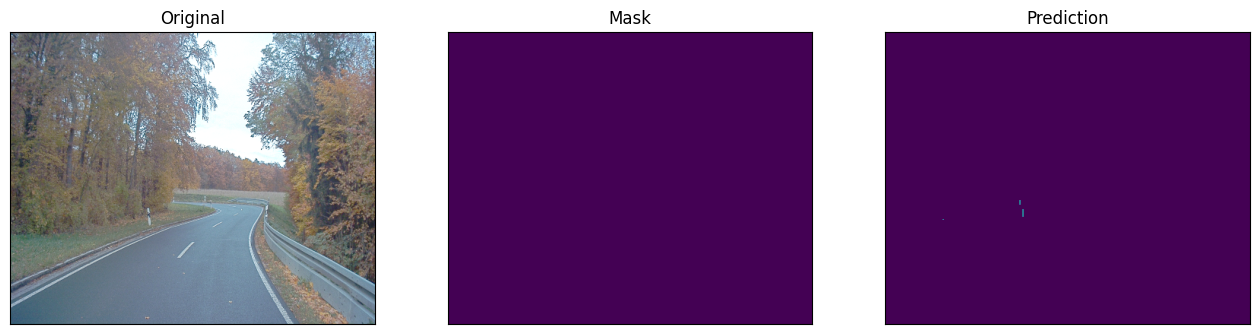

In [10]:
dirs = os.listdir(DATA_DIR_A2D2)
dirs = [i for i in dirs if '201' in i]
rand_number = randrange(len(dirs))
# rand_number = 3
print(rand_number)

directory = change_slashes(os.path.join(DATA_DIR_A2D2, dirs[rand_number]))

dir_camera = change_slashes(os.path.join(directory, "camera/cam_front_center"))
path_png_camera = [i for i in os.listdir(dir_camera) if '.png' in i][0]
# dir_camera = os.path.join(dir_camera, str(path_png_camera[0]))

dir_label = change_slashes(os.path.join(directory, "label/cam_front_center"))
path_png_label = os.listdir(dir_label)[0]
# dir_label = os.path.join(dir_label, str(path_png_label[0]))

# Convert "/" in "\"
dir_camera = change_slashes(dir_camera)
dir_label = change_slashes(dir_label)

# Read label / ground truth image
os.chdir(dir_label)

img_label = cv2.imread(str(path_png_label))
img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
img_label = cv2.resize(img_label, (480,384))
image_label_vis = img_label # for visualization

mask_pedestrian_1 = obtain_mask(img_label, "#cc99ff")
mask_pedestrian_2 = obtain_mask(img_label, "#bd499b")
mask_pedestrian_3 = obtain_mask(img_label, "#ef59bf")

mask_pedestrian = mask_pedestrian_1 + mask_pedestrian_2 + mask_pedestrian_3

# Read original image and eval in the net
os.chdir(dir_camera)

img_camera = cv2.imread(str(path_png_camera))
img_camera = cv2.cvtColor(img_camera, cv2.COLOR_BGR2RGB)
img_camera = cv2.resize(img_camera, (480,384))
img_camera_vis = img_camera # for visualization

## Evaluate and obtain prediction in pr_mask
pr_mask = eval_image(img_camera, best_model)

visualize(
    original=img_camera_vis,
    mask = mask_pedestrian,
    prediction = pr_mask
)

# for i in dirs:
#    directory = os.path.join(DATA_DIR_A2D2, i)
#    print(directory)

# Go back to the root of the project
os.chdir(ROOT)

In [11]:
%timeit pr_mask = eval_image(img_camera, best_model)

43.7 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
# IoU calculation
intersection = numpy.logical_and(mask_pedestrian, pr_mask)
union = numpy.logical_or(mask_pedestrian, pr_mask)
iou_score = numpy.sum(intersection) / numpy.sum(union)
print('IoU is %s' % iou_score)

IoU is 0.0


# Test in video.mp4

In [ ]:
# define a video capture object
vid = cv2.VideoCapture('data/video.mp4')

# Check if camera opened successfully
if (vid.isOpened()== False): 
    print("Error opening video stream or file")
    
while(vid.isOpened()):
    ret, webcam = vid.read()
    if ret == True:

        image = cv2.resize(webcam, (480,384))
        image_vis = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for visualization
        image = preprocessing_fn(image)

        image = image.transpose(2, 0, 1).astype('float32')

        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = best_model.predict(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
        visualize(
            original=image_vis,
            mask = pr_mask
        )
        clear_output(wait=True)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

vid.release()
cv2.destroyAllWindows()

In [ ]:
# Release cam/video manually in case of error in previous cell
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()